# Quick simple pixel DF/F of GA-RG GABASnFR analysis

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')
t_pre = 10 # time window pre-swim
t_post = 35 # time window post-swim
t_sig = 30 # time used for significance test after swim
t_len = t_pre+t_post
t_flat = 5
t_valid = 26

In [ ]:
vol_file = '../Analysis/depreciated/analysis_sections_GA_RG_SnFR.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [ ]:
dat_xls_file

In [ ]:
row = dat_xls_file.iloc[7]

In [192]:
row

Unnamed: 0                         8
folder                      08012019
fish                         Fish3-3
task                  GA+Random gain
area                            GABA
rootDir         /nrs/ahrens/Takashi/
pixeldenoise                    True
registration                    True
detrend                        False
demix                          False
denoise                        False
Name: 7, dtype: object

In [193]:
folder = row['folder']
fish = row['fish']
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/'
save_folder = dat_folder + f'{folder}/{fish}/Data'

In [194]:
from skimage.io import imread

In [195]:
Y_r = imread(save_folder+'/imgDMotion.tif')
Y_d = imread(save_folder+'/Y_d.tif')

In [196]:
Y_base_mean = (Y_r.transpose((1, 2, 0)) - Y_d).mean(axis=-1)
Y_mean = Y_r.mean(axis=0)
Y_std = Y_d.std(axis=-1)

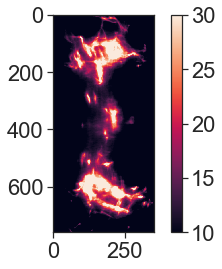

In [197]:
# plt.imshow((Y_std>2).astype('float'))
plt.imshow(Y_base_mean, vmin=10, vmax=30)
plt.colorbar()
plt.show()

In [198]:
# dFF = Y_d/(Y_r.transpose((1, 2, 0)) - Y_d)
# ave_dff = dFF[(Y_base_mean>10) & (Y_base_mean<100)].mean(axis=0)
# ave_dff = dFF[(Y_std>2)].mean(axis=0)
ave_dff = Y_d[Y_base_mean>10].mean(axis=0)/(Y_r.transpose((1, 2, 0))[Y_base_mean>10].mean(axis=0) - Y_d[Y_base_mean>10].mean(axis=0))

08012019Fish3-3


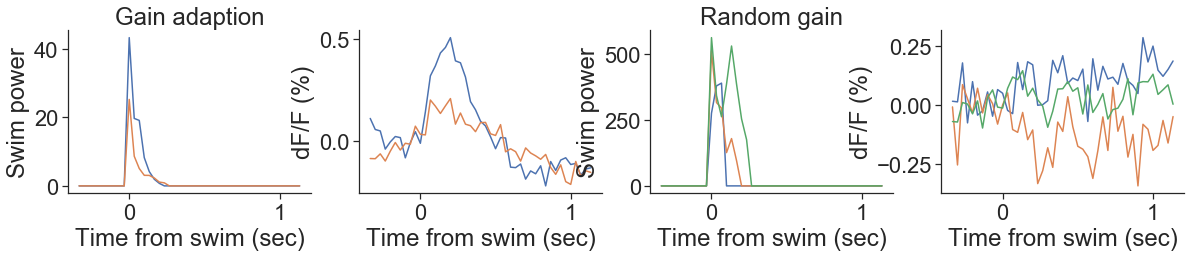

In [199]:
folder = row['folder']
fish = row['fish']
task_type = row['task']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
r_swim = _['r_swim']
l_swim = _['l_swim']
task_period = _['task_period'].astype('int')
task_period_ = _['swim_task_index'].astype('int')
visu = _['visu']
p_swim = r_swim + l_swim
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
swim_len = swim_ends - swim_starts
valid_trial = (swim_len>1) & (p_swim.sum(axis=-1)>0)

num_swim = len(swim_starts)
dff_ = np.zeros((num_swim, t_len))
for ns, s in enumerate(swim_starts):
    dff_[ns] = ave_dff[(s-t_pre):(s+t_post)] - ave_dff[(s-t_flat):s].mean()
valid_trial = (swim_len>1) & (p_swim.sum(axis=-1)>0)
valid_trial = valid_trial & (p_swim[:, -t_valid:].sum(axis=-1)==0)
valid_trial = valid_trial & (p_swim[:, :t_pre].sum(axis=-1)==0)
# valid_trial = valid_trial & ((visu[:, :t_pre]<0).mean(axis=-1)==0)
# valid_trial = valid_trial & ((visu[:, -t_valid:]<0).mean(axis=-1)==0)


print(folder + fish)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax[0].plot(np.arange(-t_pre, t_post)/30, p_swim[valid_trial & (task_period==1)].mean(axis=0))
ax[0].plot(np.arange(-t_pre, t_post)/30, p_swim[valid_trial & (task_period==3)].mean(axis=0))
sns.despine()
ax[0].set_xlabel('Time from swim (sec)')
ax[0].set_ylabel('Swim power')
ax[0].set_title('Gain adaption')
for n in range(3):
    ax[2].plot(np.arange(-t_pre, t_post)/30, p_swim[valid_trial & (task_period_==4+n)].mean(axis=0)*100)
sns.despine()
ax[2].set_xlabel('Time from swim (sec)')
ax[2].set_ylabel('Swim power')
ax[2].set_title('Random gain')
ax[1].plot(np.arange(-t_pre, t_post)/30, np.mean(dff_[valid_trial & (task_period==1)], axis=0)*100)
ax[1].plot(np.arange(-t_pre, t_post)/30, np.mean(dff_[valid_trial & (task_period==3)], axis=0)*100)
# ax[1].plot(np.arange(-t_pre, t_post)/30, dff_[valid_trial & (task_period==1)].T, color='b')
# ax[1].plot(np.arange(-t_pre, t_post)/30, dff_[valid_trial & (task_period==3)].T, color='r')
sns.despine()
ax[1].set_xlabel('Time from swim (sec)')
ax[1].set_ylabel('dF/F (%)')
for n in range(3):
    ax[3].plot(np.arange(-t_pre, t_post)/30, np.mean(dff_[valid_trial & (task_period==n+4)], axis=0)*100)
sns.despine()
ax[3].set_xlabel('Time from swim (sec)')
ax[3].set_ylabel('dF/F (%)')
plt.show()

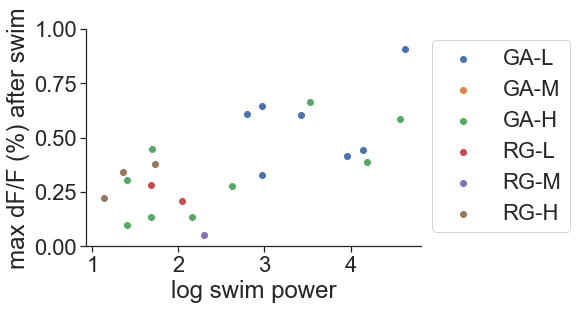

In [202]:
label_task = ['GA', 'RG']
label_gain = ['L', 'M', 'H']
labels = []
for task in label_task:
    for gain in label_gain:
        labels.append(task+'-'+gain)
for n in range(1, 7):
    plt.scatter(np.log(p_swim[valid_trial & (task_period==n)].max(axis=-1)), dff_[valid_trial & (task_period==n), t_pre:t_pre+10].max(axis=-1)*100, label=labels[n-1])
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.ylim([0, 1])
sns.despine()
plt.xlabel('log swim power')
plt.ylabel('max dF/F (%) after swim')
plt.show()